# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm import tqdm
import pandas as pd

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

import torch
import torch.nn.functional as F

from src.selfies import SelfiesEncoder
from src.vae import MolecularVAE

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

Download raw dataset:

In [7]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join("data", "qm9_raw.csv"), index=False)

Add selfies encoding to raw data:

In [248]:
def compute_logp(smile):
    mol = Chem.MolFromSmiles(smile)
    return Descriptors.MolLogP(mol)

df = pd.read_csv(os.path.join("data", "qm9_raw.csv"))
df = df[["mol_id", "smiles", "mu", "alpha", "homo", "lumo", "gap", "r2"]]
#df = df.sample(n=5000, random_state=42)

df["selfies"] = [sf.encoder(x, strict=False) for x in df.smiles]
df["logp"] = [compute_logp(s) for s in df.smiles]

df.to_csv(os.path.join("data", "qm9_processed.csv"), index=False)

Generate one-hot enocding for selfies strings:

In [4]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))
df.head()

,mol_id,smiles,mu,alpha,homo,lumo,gap,r2,selfies,logp
0,gdb_1,C,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,[C],0.63610
1,gdb_2,N,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,[N],0.16200
2,gdb_3,O,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,[O],-0.82470
3,gdb_4,C#C,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,[C][#C],0.24940
4,gdb_5,C#N,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,[C][#N],0.13978


In [5]:
selfies = df.selfies
selfies_encoder = SelfiesEncoder.build(selfies)

In [251]:
one_hots = []
for s in tqdm(selfies):
    one_hots.append(selfies_encoder.encode_one_hot(s))
one_hots = torch.tensor(one_hots)
torch.save(one_hots, os.path.join(data_path, "qm9_encodings.pt"))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:03<00:00, 36035.57it/s]


# VAE

In [15]:
def compute_loss(x, x_recon, z_mean, z_logvar):
    # Cross entropy should be computed across one-hot labels, so transpose tensors so labels in dim=1
    bce = F.cross_entropy(x_recon.transpose(2, 1), x.transpose(2, 1), reduction="sum")
    kld = -0.5 * torch.sum(1.0 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return bce + kld

def reconstruction_count(x, x_recon):
    actual_labels = x.argmax(dim=-1)
    recon_labels = x_recon.argmax(dim=-1)
    return (recon_labels == actual_labels).all(dim=-1).sum().item()

def train_one_epoch(model, optimizer, scheduler, data_loader):
    model.train()

    total_loss = 0.0
    total_recon = 0
    for x, _ in data_loader:
        optimizer.zero_grad()
        x_recon, z_mean, z_logvar = model(x)
        loss = compute_loss(x, x_recon, z_mean, z_logvar)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += reconstruction_count(x, x_recon)

    if scheduler is not None:
        scheduler.step()

    n = len(data_loader.dataset)
    return total_loss / n, total_recon / n

@torch.no_grad()
def test_one_epoch(model, data_loader):
    model.eval()

    total_loss = 0.0
    total_recon = 0
    for x, _ in data_loader:
        x_recon, z_mean, z_logvar = model(x)
        loss = compute_loss(x, x_recon, z_mean, z_logvar)
        total_loss += loss.item()
        total_recon += reconstruction_count(x, x_recon)

    n = len(data_loader.dataset)
    return total_loss / n, total_recon / n

def train(model, optimizer, train_loader, test_loader, n_epochs, scheduler=None, print_every=10):    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    for epoch in range(n_epochs):
        train_loss_epoch, train_accuracy_epoch = train_one_epoch(model, optimizer, scheduler, train_loader)
        train_losses.append(train_loss_epoch)
        train_accuracies.append(train_accuracy_epoch)

        test_loss_epoch, test_accuracy_epoch = test_one_epoch(model, train_loader)
        test_losses.append(test_loss_epoch)
        test_accuracies.append(test_accuracy_epoch)

        if epoch == 0 or (epoch + 1) % print_every == 0:
            current_lr = optimizer.param_groups[0]["lr"]
            print(
                f"Epoch {epoch+1} | Train Loss = {train_loss_epoch:.4f} | Test loss = {test_loss_epoch:.4f} | "
                f"Train Accuracy = {train_accuracy_epoch:.4f} | Test Accuracy = {test_accuracy_epoch:.4f} | "
                f"LR = {current_lr:.3e}"
            )
    
    return train_losses, test_losses

In [16]:
torch.manual_seed(42)
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

x = torch.load(os.path.join("data", "qm9_encodings.pt"))
x = x.float().to(device)
full_dataset =  torch.utils.data.TensorDataset(x)

test_frac = 0.1
test_size = int(test_frac * len(x))
train_size = len(x) - test_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [17]:
batch_size = 250

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
model = MolecularVAE(latent_size=50)
model.to(device)

print(f"# Parameters = {model.n_parameters()}")
model

# Parameters = 673235


MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(9, 10, kernel_size=(10,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=80, out_features=150, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=150, out_features=50, bias=True)
  (encoder_logvar): Linear(in_features=150, out_features=50, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(50, 200, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=200, out_features=29, bias=True)
)

In [19]:
learning_rate = 2e-3
weight_decay = 1e-5

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [22]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

In [23]:
n_epochs = 100
train_losses, test_losses = train(
    model, 
    optimizer, 
    train_loader, 
    test_loader, 
    n_epochs=n_epochs,
    scheduler=scheduler,
    print_every=1
)

Epoch 1 | Train Loss = 1.8443 | Test loss = 1.8179 | Train Accuracy = 0.5484 | Test Accuracy = 0.5569 | LR = 6.250e-05
Epoch 2 | Train Loss = 1.8377 | Test loss = 1.8148 | Train Accuracy = 0.5497 | Test Accuracy = 0.5554 | LR = 6.250e-05
Epoch 3 | Train Loss = 1.8332 | Test loss = 1.8227 | Train Accuracy = 0.5514 | Test Accuracy = 0.5556 | LR = 6.250e-05
Epoch 4 | Train Loss = 1.8312 | Test loss = 1.8114 | Train Accuracy = 0.5520 | Test Accuracy = 0.5577 | LR = 6.250e-05
Epoch 5 | Train Loss = 1.8419 | Test loss = 1.8107 | Train Accuracy = 0.5472 | Test Accuracy = 0.5584 | LR = 6.250e-05
Epoch 6 | Train Loss = 1.8304 | Test loss = 1.8067 | Train Accuracy = 0.5523 | Test Accuracy = 0.5586 | LR = 6.250e-05
Epoch 7 | Train Loss = 1.8294 | Test loss = 1.8074 | Train Accuracy = 0.5526 | Test Accuracy = 0.5581 | LR = 6.250e-05
Epoch 8 | Train Loss = 1.8266 | Test loss = 1.8064 | Train Accuracy = 0.5531 | Test Accuracy = 0.5569 | LR = 6.250e-05
Epoch 9 | Train Loss = 1.8258 | Test loss = 1.80

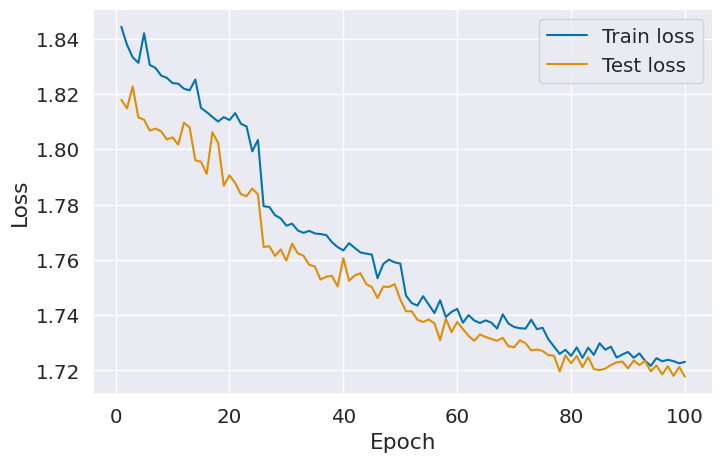

In [25]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(1, n_epochs + 1), train_losses, label='Train loss')
ax.plot(range(1, n_epochs + 1), test_losses, label='Test loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

In [31]:
torch.save(model.state_dict(), os.path.join("models", "vae_latent50.pt"))

# Flory

In [5]:
n_components = 2
objective = FloryHuggins(n_components)
objective.set_size(0, 1)
objective.set_pairwise(0, 1, 3.0)

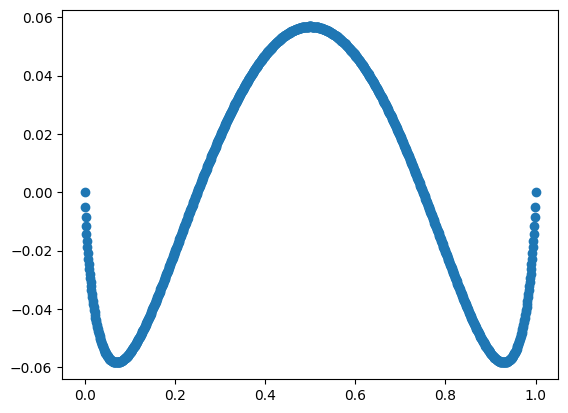

In [6]:
n = 1000

x0 = torch.linspace(0.0, 1.0, n)
x1 = 1.0 - x0

x = torch.stack([x0, x1], dim=1)
y = objective(x)

plt.scatter(x[:,1], y)
plt.show()